## Notebook Import

In [8]:
from os.path import join
import sys

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, HashingVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords


from wordcloud import WordCloud
from bs4 import BeautifulSoup
from PIL import Image

%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s158025\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s158025\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Constants

In [3]:
data_path = 'IMDB_Movie_Reviews'

THUMBS_UP_FILE = 'IMDB_Movie_Reviews/thumbs-up.png'
THUMBS_DOWN_FILE = 'IMDB_Movie_Reviews/thumbs-down.png'

## Reading Data

In [4]:
reviews_path = join(data_path, 'IMDB_Dataset.csv')

reviews_df = pd.read_csv(reviews_path)

## Explore Data

In [6]:
reviews_df.shape

(50000, 2)

In [7]:
reviews_df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Data Cleaning: checking for missing values

In [ ]:
reviews_df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
(reviews_df.review.str.len() == 0).sum()

0

## Data Visualisation

In [ ]:
reviews_df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

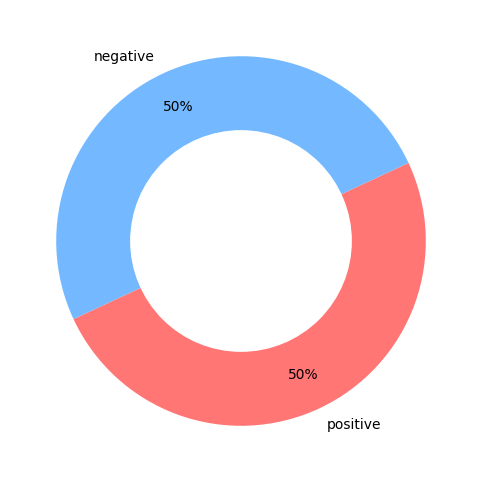

In [ ]:
explode = (0.05, 0.05)


plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=['#ff7675', '#74b9ff'],
        startangle=205, textprops={'fontsize':10}, pctdistance=0.8,)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)


plt.show()

### Apply NLP

In [ ]:
def clean_rev_no_html(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):

    cleantext = BeautifulSoup(message, 'html.parser').get_text()

    ps = stemmer

    filtered_words = []
    for word in word_tokenize(cleantext.lower()):
        if not word in stop_words and word.isalpha():
            filtered_words.append(ps.stem(word))

    return filtered_words

In [ ]:
nested_filtered_words = reviews_df['review'].apply(clean_rev_no_html)

nested_filtered_words.head()

<ipython-input-140-9ba809010da2>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleantext = BeautifulSoup(message, 'html.parser').get_text()


0    [one, review, mention, watch, oz, episod, hook...
1    [wonder, littl, product, film, techniqu, fashi...
2    [thought, wonder, way, spend, time, hot, summe...
3    [basic, famili, littl, boy, jake, think, zombi...
4    [petter, mattei, love, time, money, visual, st...
Name: review, dtype: object

In [ ]:
nested_filtered_words.tail()

49995    [thought, movi, right, good, job, creativ, ori...
49996    [bad, plot, bad, dialogu, bad, act, idiot, dir...
49997    [cathol, taught, parochi, elementari, school, ...
49998    [go, disagre, previou, comment, side, maltin, ...
49999    [one, expect, star, trek, movi, high, art, fan...
Name: review, dtype: object

In [ ]:
nested_list_pos = nested_filtered_words[reviews_df.sentiment == 'positive']
nested_list_neg = nested_filtered_words[reviews_df.sentiment == 'negative']

In [ ]:
word_list_pos = [word for sublist in nested_list_pos for word in sublist]

pos_words = pd.Series(word_list_pos).value_counts()

print('the total number of words in pos reviews in the dataset is:', len(pos_words) )
print('the 10 most common words used in pos reviews:\n', pos_words.sort_values(ascending = False)[:10])

the total number of words in pos reviews in the dataset is: 50152
the 10 most common words used in pos reviews:
 film       49345
movi       43477
one        27142
like       19972
time       15600
see        14738
good       14676
stori      13725
charact    13704
make       13176
dtype: int64


In [ ]:
word_list_neg = [word for sublist in nested_list_neg for word in sublist]

neg_words = pd.Series(word_list_neg).value_counts()

print('the total number of words in negative reviews in the dataset is:', len(neg_words) )
print('the 10 most common words used in negative reviews:\n', neg_words.sort_values(ascending = False)[:10])

the total number of words in negative reviews in the dataset is: 48128
the 10 most common words used in negative reviews:
 movi     56338
film     43359
one      25879
like     24048
make     15422
even     15225
would    15211
get      15159
watch    14651
time     14490
dtype: int64


### Word Cloud of pos and negative reviews

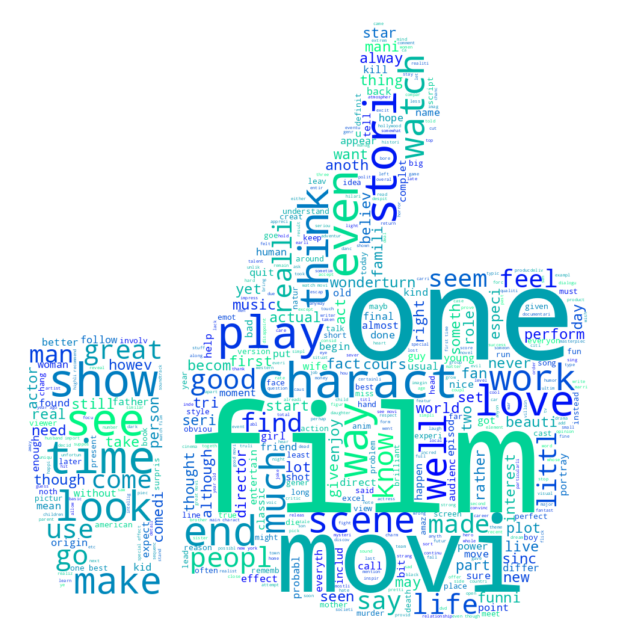

In [ ]:
pos_as_string = ' '.join(word_list_pos)

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=500, colormap='winter')
word_cloud.generate(pos_as_string)

plt.figure(figsize=[12, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

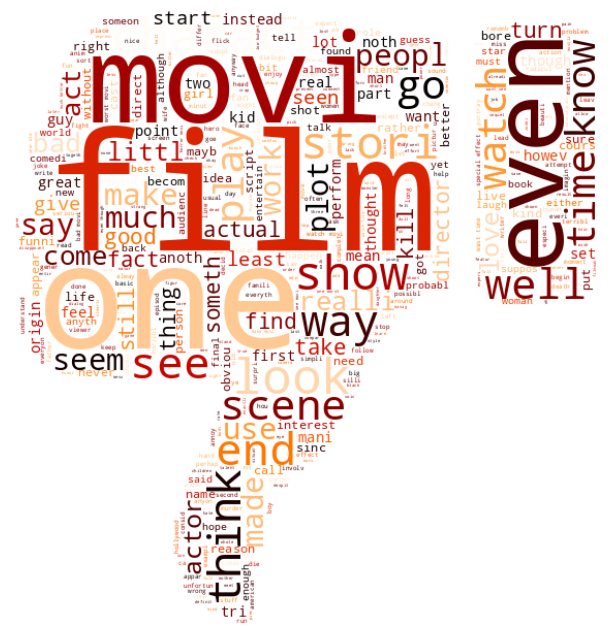

In [ ]:
neg_as_string = ' '.join(word_list_neg)

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=2000, colormap='gist_heat')
word_cloud.generate(neg_as_string)

plt.figure(figsize=[12, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## NLP - Bag Of Words

In [6]:
reviews = list(reviews_df['review'])
reviews = [review.replace('<br />', '') for review in reviews]
sentiment = reviews_df['sentiment']
reviews[1]

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

In [9]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)

print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())

negative    20039
positive    19961
Name: sentiment, dtype: int64
-----------------------
positive    5039
negative    4961
Name: sentiment, dtype: int64


In [10]:
vector = CountVectorizer()
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)

print(dev_X.shape)
print(test_X.shape)

(40000, 94886)
(10000, 94886)


In [11]:
feature_names = vector.get_feature_names_out()
print(feature_names[:10])
print(feature_names[10000:10020])

['00' '000' '00000000000' '00000001' '00001' '00015' '000dm' '000s' '001'
 '003830']
['blayde' 'blaylak' 'blaylock' 'blaze' 'blazed' 'blazer' 'blazers'
 'blazes' 'blazing' 'blaznee' 'bleach' 'bleached' 'bleachers' 'bleaching'
 'bleah' 'bleak' 'bleaked' 'bleaker' 'bleakest' 'bleakly']


In [13]:
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

0.9007

In [14]:
feature_names = vector.get_feature_names_out()
feature_coef = lr.coef_[0]
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coef})
sorted_coefficients = coefficients_df.sort_values(by='Coefficient',)

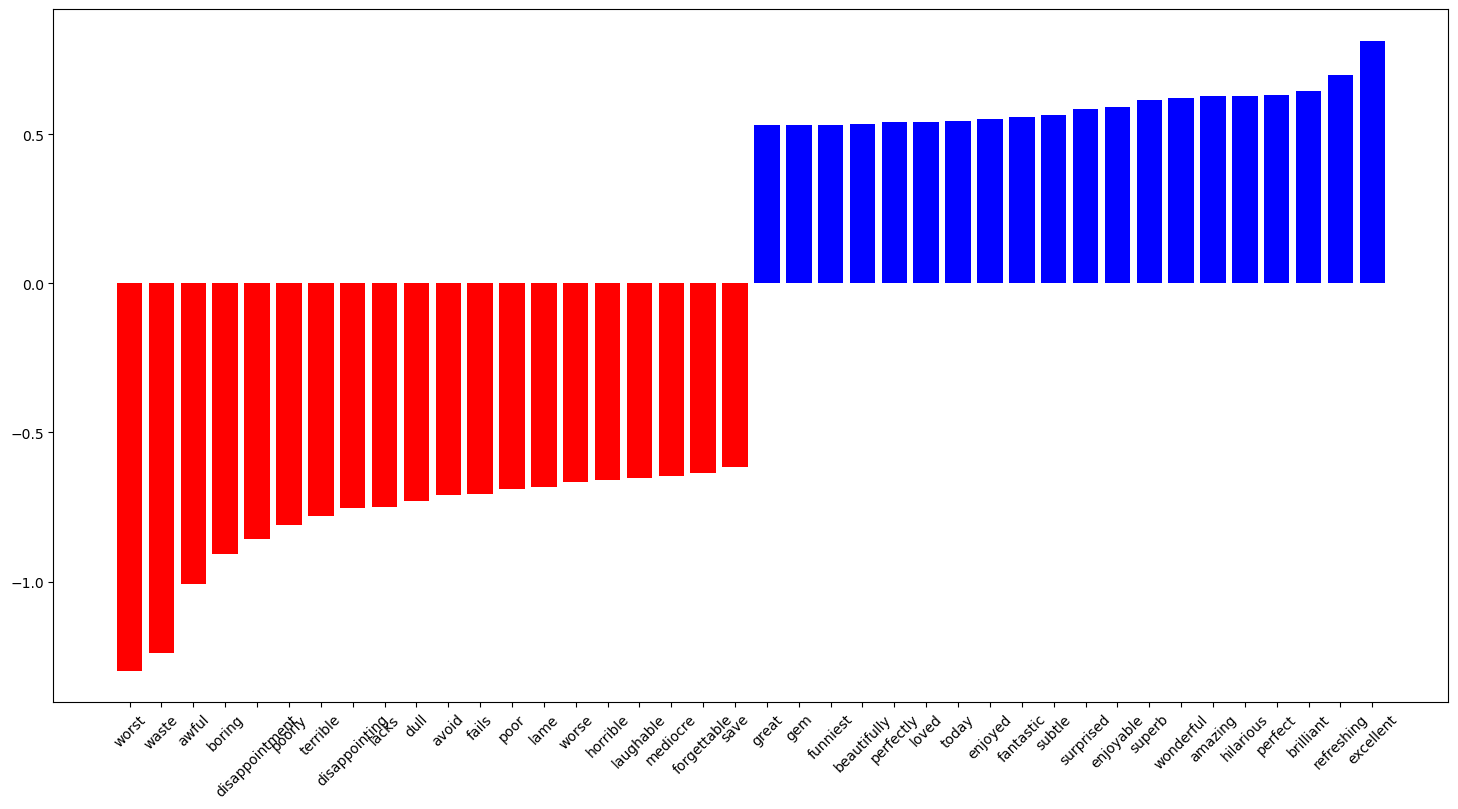

In [15]:
top_features = 20

plt.figure(figsize=(18, 9))
plt.bar(range(top_features), sorted_coefficients['Coefficient'][:top_features], color='red', label='Negative')
plt.bar(range(top_features, top_features*2), sorted_coefficients['Coefficient'][-top_features:], color='blue', label='Positive')

plt.xticks(range(top_features*2),
           sorted_coefficients['Feature'][:top_features].tolist() + sorted_coefficients['Feature'][-top_features:].tolist(),
           rotation=45)
plt.show()

## NLP - Bag Of Words + stop words

In [17]:
vector_stop_words = CountVectorizer(stop_words='english')
dev_X = vector_stop_words.fit_transform(dev_text)
test_X = vector_stop_words.transform(test_text)

print(dev_X.shape)
print(test_X.shape)

(40000, 94575)
(10000, 94575)


In [18]:
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

0.8919

## NLP - Bag Of Words + Infrequent Words

In [19]:
vector_infrequent_words = CountVectorizer(min_df=4)
dev_X = vector_infrequent_words.fit_transform(dev_text)
test_X = vector_infrequent_words.transform(test_text)
print(dev_X.shape)

(40000, 37699)


In [20]:
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

0.9004

## NLP -  Stemming

In [23]:
porter = PorterStemmer()
def stemSentence(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return " ".join(stem_sentence)

In [24]:
reviews_stem = [stemSentence(review) for review in reviews]
reviews_stem[1]

"a wonder littl product . the film techniqu is veri unassuming- veri old-time-bbc fashion and give a comfort , and sometim discomfort , sens of realism to the entir piec . the actor are extrem well chosen- michael sheen not onli `` ha got all the polari '' but he ha all the voic down pat too ! you can truli see the seamless edit guid by the refer to william ' diari entri , not onli is it well worth the watch but it is a terrificli written and perform piec . a master product about one of the great master 's of comedi and hi life . the realism realli come home with the littl thing : the fantasi of the guard which , rather than use the tradit 'dream ' techniqu remain solid then disappear . it play on our knowledg and our sens , particularli with the scene concern orton and halliwel and the set ( particularli of their flat with halliwel 's mural decor everi surfac ) are terribl well done ."

In [25]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews_stem, sentiment, test_size=0.2, random_state=42)

print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())

negative    20039
positive    19961
Name: sentiment, dtype: int64
-----------------------
positive    5039
negative    4961
Name: sentiment, dtype: int64


In [26]:
vector = CountVectorizer()
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)
print(dev_X.shape)

(40000, 75073)


In [27]:
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

0.8935

In [28]:
feature_names = vector.get_feature_names_out()
feature_coef = lr.coef_[0]
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coef})
sorted_coefficients = coefficients_df.sort_values(by='Coefficient',)

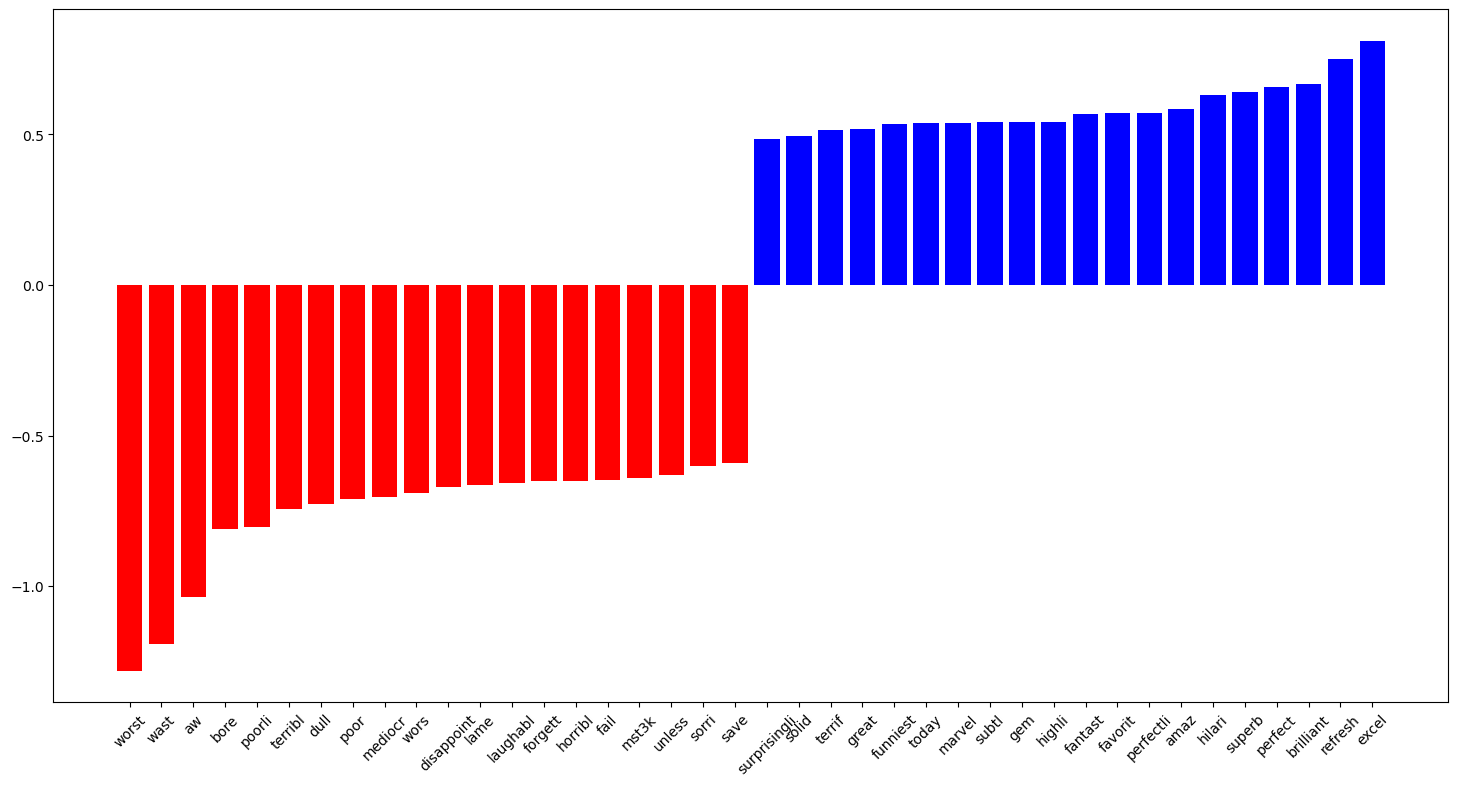

In [29]:
top_features = 20

plt.figure(figsize=(18, 9))
plt.bar(range(top_features), sorted_coefficients['Coefficient'][:top_features], color='red', label='Negative')
plt.bar(range(top_features, top_features*2), sorted_coefficients['Coefficient'][-top_features:], color='blue', label='Positive')

plt.xticks(range(top_features*2),
           sorted_coefficients['Feature'][:top_features].tolist() + sorted_coefficients['Feature'][-top_features:].tolist(),
           rotation=45)
plt.show()

## NLP - Stemming + Infrequent Words

In [31]:
vector_infrequent_words = CountVectorizer(min_df=4)
dev_X = vector_infrequent_words.fit_transform(dev_text)
test_X = vector_infrequent_words.transform(test_text)
print(dev_X.shape)

(40000, 27157)


In [32]:
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

0.8929

## NLP - Stemming + Stop words

In [35]:
vector_stop_words = CountVectorizer(stop_words='english')
dev_X = vector_stop_words.fit_transform(dev_text)
test_X = vector_stop_words.transform(test_text)
print(dev_X.shape)

(40000, 74778)


In [36]:
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

0.8856

## NLP - TF-IDF + infrequent words

In [44]:
porter = PorterStemmer()
reviews_stem = [stemSentence(review) for review in reviews]
dev_text, test_text, dev_y, test_y = train_test_split(reviews_stem, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = TfidfVectorizer(min_df=4)
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)
lr = LogisticRegressionCV(max_iter=2000).fit(dev_X, dev_y)
lr.score(test_X, test_y)

negative    20039
positive    19961
Name: sentiment, dtype: int64
-----------------------
positive    5039
negative    4961
Name: sentiment, dtype: int64


0.8973

In [45]:
feature_names = vector.get_feature_names_out()
feature_coef = lr.coef_[0]
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coef})
sorted_coefficients = coefficients_df.sort_values(by='Coefficient',)

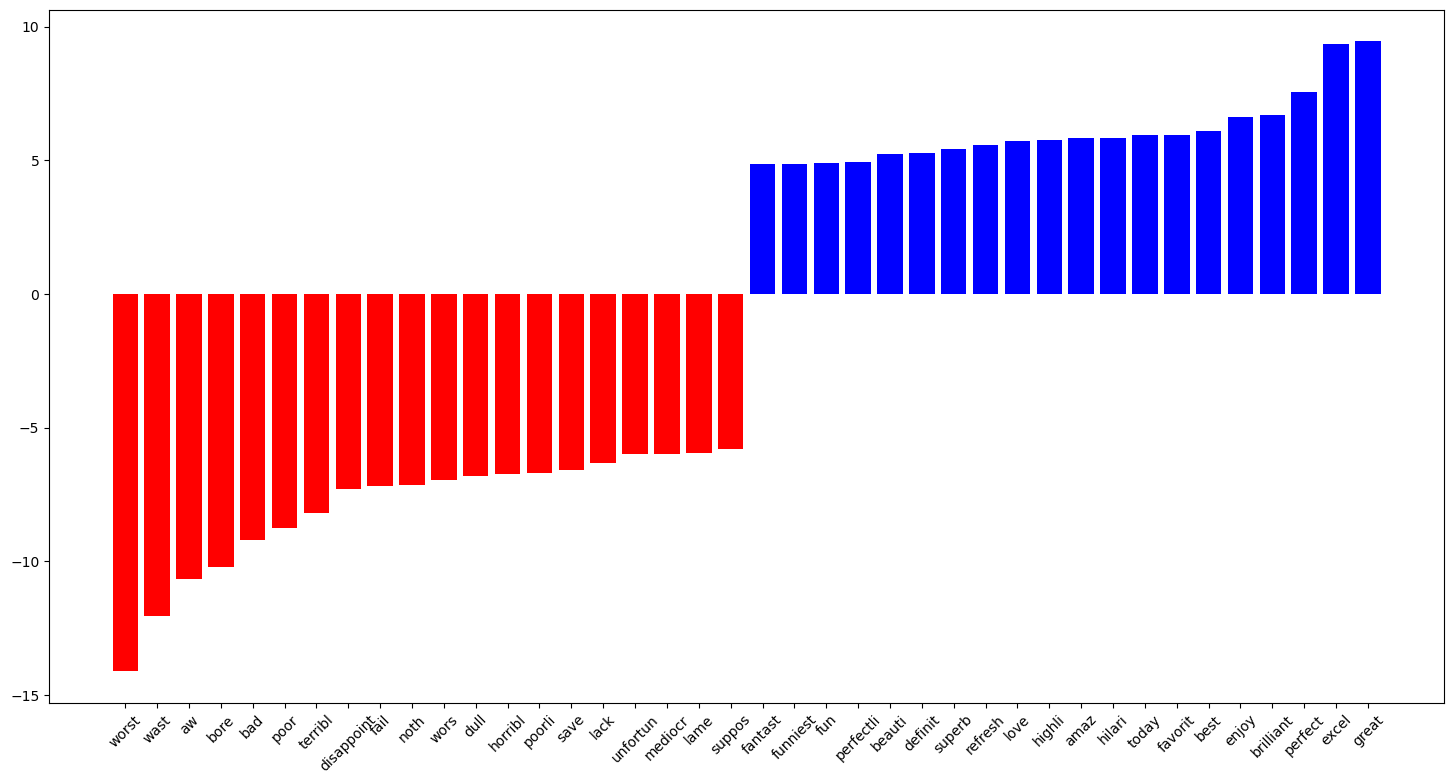

In [46]:
top_features = 20

plt.figure(figsize=(18, 9))
plt.bar(range(top_features), sorted_coefficients['Coefficient'][:top_features], color='red', label='Negative')
plt.bar(range(top_features, top_features*2), sorted_coefficients['Coefficient'][-top_features:], color='blue', label='Positive')

plt.xticks(range(top_features*2),
           sorted_coefficients['Feature'][:top_features].tolist() + sorted_coefficients['Feature'][-top_features:].tolist(),
           rotation=45)
plt.show()

## NLP - TF-IDF + stop words

In [47]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)

print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = TfidfVectorizer(stop_words='english')
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)
lr = LogisticRegressionCV(max_iter=2000).fit(dev_X, dev_y)
lr.score(test_X, test_y)

negative    20039
positive    19961
Name: sentiment, dtype: int64
-----------------------
positive    5039
negative    4961
Name: sentiment, dtype: int64


0.8972

In [48]:
feature_names = vector.get_feature_names_out()
feature_coef = lr.coef_[0]
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coef})
sorted_coefficients = coefficients_df.sort_values(by='Coefficient',)

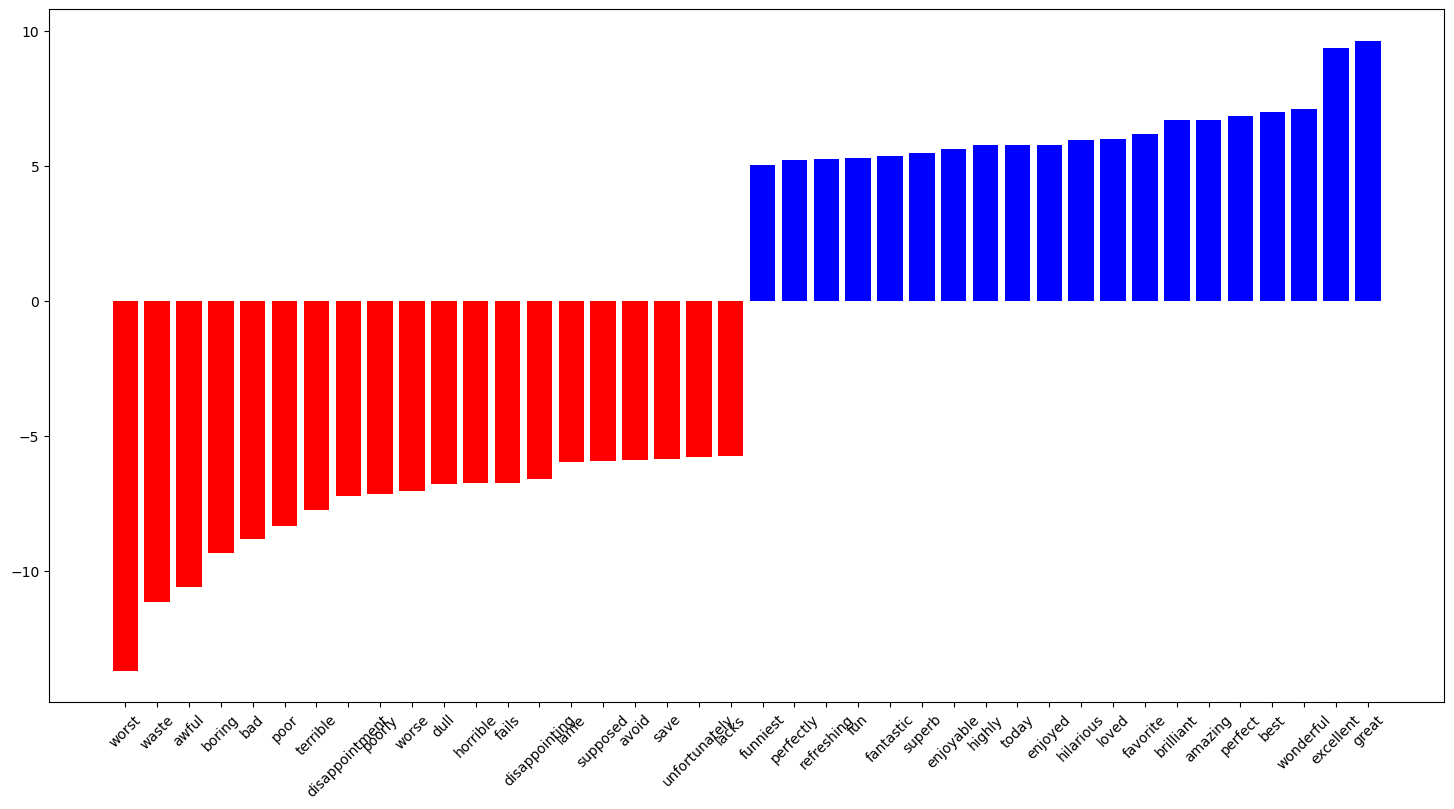

In [49]:
top_features = 20

plt.figure(figsize=(18, 9))
plt.bar(range(top_features), sorted_coefficients['Coefficient'][:top_features], color='red', label='Negative')
plt.bar(range(top_features, top_features*2), sorted_coefficients['Coefficient'][-top_features:], color='blue', label='Positive')

plt.xticks(range(top_features*2),
           sorted_coefficients['Feature'][:top_features].tolist() + sorted_coefficients['Feature'][-top_features:].tolist(),
           rotation=45)
plt.show()

## NLP - N-grams

In [51]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = CountVectorizer(ngram_range=(1,2), min_df=4)
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

negative    20039
positive    19961
Name: sentiment, dtype: int64
-----------------------
positive    5039
negative    4961
Name: sentiment, dtype: int64


0.9085

In [52]:
feature_names = vector.get_feature_names_out()
feature_coef = lr.coef_[0]
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coef})
sorted_coefficients = coefficients_df.sort_values(by='Coefficient',)

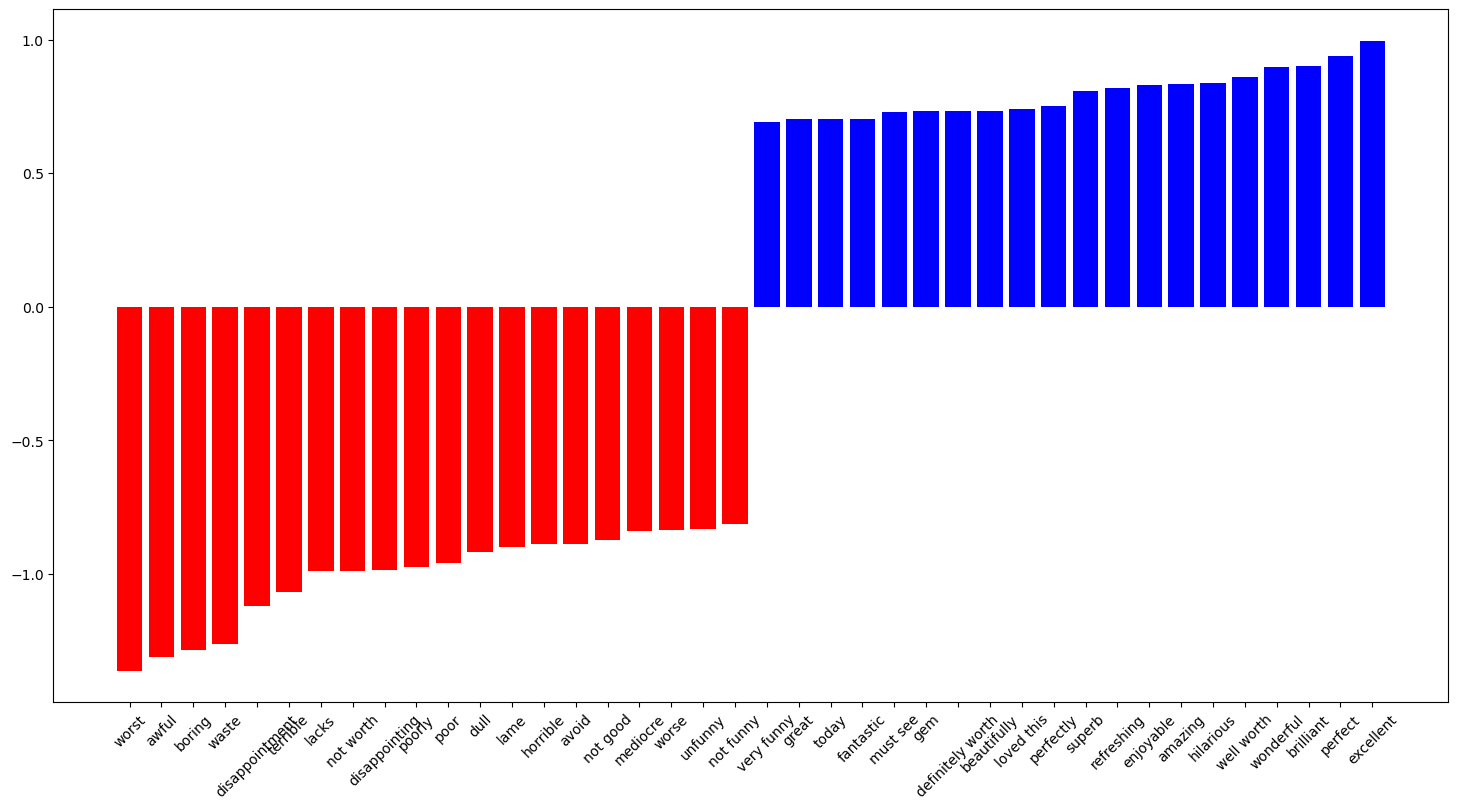

In [53]:
top_features = 20

plt.figure(figsize=(18, 9))
plt.bar(range(top_features), sorted_coefficients['Coefficient'][:top_features], color='red', label='Negative')
plt.bar(range(top_features, top_features*2), sorted_coefficients['Coefficient'][-top_features:], color='blue', label='Positive')

plt.xticks(range(top_features*2),
           sorted_coefficients['Feature'][:top_features].tolist() + sorted_coefficients['Feature'][-top_features:].tolist(),
           rotation=45)
plt.show()

In [54]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = CountVectorizer(ngram_range=(1,4), min_df=4,
                         stop_words='english')
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)
lr = LogisticRegressionCV(max_iter=2000, n_jobs=-1).fit(dev_X, dev_y)
lr.score(test_X, test_y)

negative    20039
positive    19961
Name: sentiment, dtype: int64
-----------------------
positive    5039
negative    4961
Name: sentiment, dtype: int64


0.896

In [55]:
feature_names = vector.get_feature_names_out()
feature_coef = lr.coef_[0]
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coef})
sorted_coefficients = coefficients_df.sort_values(by='Coefficient',)

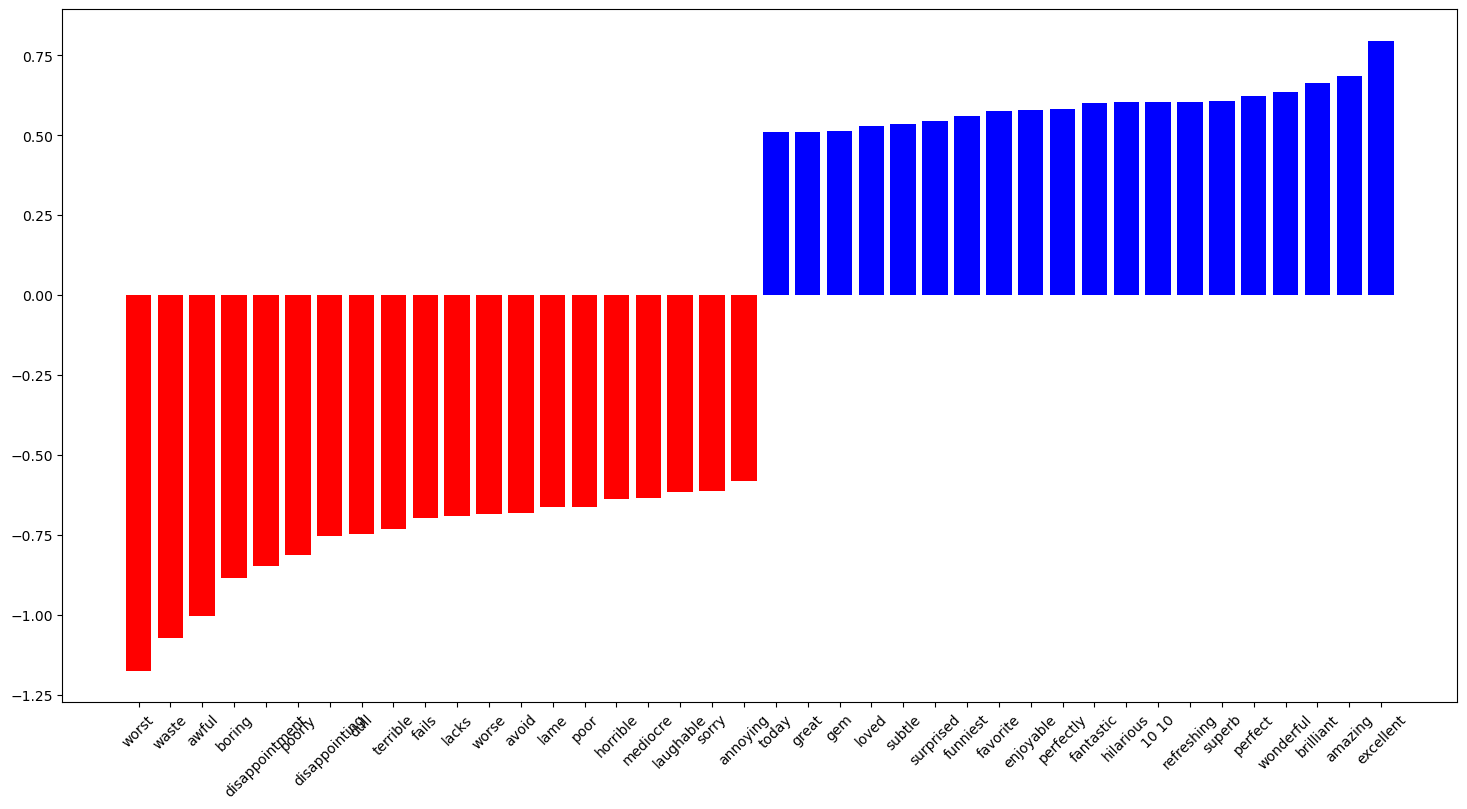

In [56]:
top_features = 20

plt.figure(figsize=(18, 9))
plt.bar(range(top_features), sorted_coefficients['Coefficient'][:top_features], color='red', label='Negative')
plt.bar(range(top_features, top_features*2), sorted_coefficients['Coefficient'][-top_features:], color='blue', label='Positive')

plt.xticks(range(top_features*2),
           sorted_coefficients['Feature'][:top_features].tolist() + sorted_coefficients['Feature'][-top_features:].tolist(),
           rotation=45)
plt.show()

## Lasso Logistic Regression - hyperparameter tuning - NLP - N-grams

In [11]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = CountVectorizer(ngram_range=(1,2), min_df=4)
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)

pipe = make_pipeline(GridSearchCV(LogisticRegression(),
                                  param_grid = [{"penalty":['l1'],
                                                 "solver":["liblinear"],
                                                 "C":np.logspace(-3, 3, 10)}],
                                  return_train_score=True))

pipe.fit(dev_X, dev_y)
grid_search_results = pipe.named_steps["gridsearchcv"]
print(f'Best score:', grid_search_results.best_score_)
print(f'Best alpha:', grid_search_results.best_params_)    
print(f"Test score:", pipe.score(test_X, test_y))

negative    20039
positive    19961
Name: sentiment, dtype: int64
-----------------------
positive    5039
negative    4961
Name: sentiment, dtype: int64
Best score: 0.89635
Best alpha: {'C': 215.44346900318823, 'penalty': 'l1', 'solver': 'liblinear'}
Test score: 0.901


## Ridge Logistic Regression - hyperparameter tuning - NLP - N-grams

In [ ]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = CountVectorizer(ngram_range=(1,2), min_df=4)
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)


pipe = make_pipeline(GridSearchCV(LogisticRegression(max_iter=2000),
                                  param_grid = [{"penalty":['l2'],
                                                 "solver":["sag"],
                                                 "C":np.logspace(-3, 3, 10)}],
                                  return_train_score=True))

pipe.fit(dev_X, dev_y)
grid_search_results = pipe.named_steps["gridsearchcv"]
print(f'Best score:', grid_search_results.best_score_)
print(f'Best alpha:', grid_search_results.best_params_)    
print(f"Test score:", pipe.score(test_X, test_y))

## Elastic Net Logistic Regression - hyperparameter tuning - NLP - N-grams

In [ ]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = CountVectorizer(ngram_range=(1,2), min_df=4)
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)

pipe = make_pipeline(GridSearchCV(LogisticRegression(max_iter=2000),
                                  param_grid = [{"penalty":['elasticnet'],
                                                 "solver":["saga"],
                                                 "C":np.logspace(-3, 3, 10),
                                                "l1_ratio": np.linspace(0, 1, 10)}],
                                  return_train_score=True))

pipe.fit(dev_X, dev_y)
grid_search_results = pipe.named_steps["gridsearchcv"]
print(f'Best score:', grid_search_results.best_score_)
print(f'Best alpha:', grid_search_results.best_params_)    
print(f"Test score:", pipe.score(test_X, test_y))

## Soft-Margin SVMs - hyperparameter tuning - NLP - N-grams

In [ ]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = CountVectorizer(ngram_range=(1,2), min_df=4)
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)


pipe = make_pipeline(GridSearchCV(SVC(),
                                  param_grid = {"kernel":['linear'],
                                                 "C":np.logspace(-3, 3, 20)},                                                          
                                  return_train_score=True))

pipe.fit(dev_X, dev_y)
grid_search_results = pipe.named_steps["gridsearchcv"]
print(f'Best score:', grid_search_results.best_score_)
print(f'Best alpha:', grid_search_results.best_params_)    
print(f"Test score:", pipe.score(test_X, test_y))

## Kernel SVMs - hyperparameter tuning - NLP - N-grams

In [ ]:
dev_text, test_text, dev_y, test_y = train_test_split(reviews, sentiment, test_size=0.2, random_state=42)
print(dev_y.value_counts())
print('-----------------------')
print(test_y.value_counts())
vector = CountVectorizer(ngram_range=(1,2), min_df=4)
dev_X = vector.fit_transform(dev_text)
test_X = vector.transform(test_text)

pipe = make_pipeline(GridSearchCV(SVC(),
                                  param_grid = {"kernel":['rbf'],
                                                 "C":np.logspace(-3, 3, 20),
                                               "gamma":np.logspace(-3, 1, 10)},                                                          
                                  return_train_score=True))

pipe.fit(dev_X, dev_y)
grid_search_results = pipe.named_steps["gridsearchcv"]
print(f'Best score:', grid_search_results.best_score_)
print(f'Best alpha:', grid_search_results.best_params_)    
print(f"Test score:", pipe.score(test_X, test_y))